# Does fire beget fire? Analysis notebook

## Nathan Korinek

This is a notebook utilizing a fire reburn dataset developed in order to answer two questions: 

1. What effect do previous burns have on fire severity across the western US? 
2. Does time between fires change the effect of repeat burns on severity? If so, does the difference in severity of the burns change over time? 

The reburn dataset has each row as a reburn event, with climate, topographical, and severity data for both the first and second fire that occured. Reburned and non reburned areas during the second fire are the focus of this, specifically finding how severity differs between reburned and non reburned areas during the same fire. 

In [1]:
# Import libraries
import os
from os.path import join
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
from rasterio.plot import plotting_extent
from glob import glob
import earthpy.plot as ep
import warnings
from shapely.geometry import box
from scipy.stats import shapiro
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap
warnings.filterwarnings('ignore')

# Setting directory paths
home = os.path.dirname(os.path.realpath("__file__"))
data_folder = join(home, "data")

final_gdf_path = join(data_folder, "firedpy_overlay_full", "firedpy_overlay_full_vpd.geojson")

### Opening the fire and reburn data 

This datasets being opened are the two datasets made for this study. The first is the a fire only dataset, not looking at reburns. In this dataset, there is basic information on the fires, such as their length, geometries, and severities. 

The second dataset is one that contains the reburn data, with reburn events and data about severity, climate, and topotgraphy for every area of interest in this study.

In [2]:
final_gdf = gpd.read_file(final_gdf_path)

# Opening dataset with all fires
full_gdf_path = join(data_folder, "firedpy_severities", "firedpy_severities.shp")
full_gdf = gpd.read_file(full_gdf_path)

# Opening the reburn dataset
overlay_gdf_path = join(data_folder, "firedpy_severities_overlay", "firedpy_severities_overlay.shp")
overlay_gdf = gpd.read_file(overlay_gdf_path)

### EPA Ecoregions Data

This code opens the EPA level 3 ecoregions dataset, and selects only the ecoregions in the study area.

In [3]:
full_eco_path = join(
    data_folder, "EPA-ecoregions", "us_eco_l3", "us_eco_l3.shp"
)

full_eco = gpd.read_file(full_eco_path)

# Selecting only western EPA level 3 ecoregions
western_forests_regions = ([str(i) for i in list(range(27))] + 
[str(i) for i in list(range(41, 44))] +
[str(i) for i in list(range(77, 82))] 
)

western_epa = full_eco[full_eco['US_L3CODE'].isin(western_forests_regions)].to_crs(full_gdf.crs)

In [4]:
# Creating a dictionary that can be used to change ecoregions code to its real name

ecoregion_dict = {}
for i, group in western_epa.groupby('US_L3CODE'):
    ecoregion_dict[i] = group['US_L3NAME'].values[0]

### Functions

This analysis required the use of many complicated functions. They are broken into
sections as to what their purpose is. 

#### Plotting Functions

These functions were used to plot and map the data to create helpful visuals

In [5]:
def plot_fire_overlay(fire1_id, fire2_id, year, title, year2=None):
    """
    Plot overlay of two fire geometries, with optional comparison between two years of data.

    Parameters
    -----------
    fire1_id : int
        The unique identifier for the first fire geometry.
    fire2_id : int
        The unique identifier for the second fire geometry.
    year : int
        The year of the first fire severity data.
    title : str
        The title for the plot.
    year2 : int, optional
        The year of the second fire severity data, used for comparison if provided.
    """
    # Select fire geometries
    path = glob(join(data_folder, "landfire_cbi", "full_cbi_annual", "*{}*.tif".format(year)))[0]
    fire1 = full_gdf[full_gdf["id"] == fire1_id]
    fire2 = full_gdf[full_gdf["id"] == fire2_id]
    bbox = get_bounding_box(fire1, fire2)
    arr = rxr.open_rasterio(path).rio.clip([bbox], from_disk=True).squeeze() / 10000
    extent = plotting_extent(arr.values, arr.rio.transform())

    # Optional second year comparison
    if year2:
        path2 = glob(join(data_folder, "landfire_cbi", "full_cbi_annual", "*{}*.tif".format(year2)))[0]
        arr2 = rxr.open_rasterio(path2).rio.clip([bbox], from_disk=True).squeeze() / 10000

    # Select overlay geometries
    diff = final_gdf[(final_gdf["fire1_id"] == fire1_id) & (final_gdf["fire2_id"] == fire2_id)]
    overlay = overlay_gdf[(overlay_gdf["id_1"] == fire1_id) & (overlay_gdf["id_2"] == fire2_id)]

    # Create figure and axes
    if year2:
        fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
    else:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Plot for the second year if year2 is provided
    if year2:
        diff.boundary.plot(ax=ax, color='orange', linewidth=9, label='Non Reburned Outline', zorder=1)
        diff.boundary.plot(ax=ax2, color='orange', linewidth=9, label='Non Reburned Outline')
        fire1.boundary.plot(ax=ax2, color='black', linewidth=3, label='Fire 1 Outline')
        fire2.boundary.plot(ax=ax2, color='blue', linewidth=3, label='Fire 2 Outline')
        overlay.boundary.plot(ax=ax2, color='green', linewidth=3, label='Reburned Outline')
        ep.plot_bands(arr2, extent=extent, cmap='hot_r', ax=ax2, cbar=False)

        ax2.set_xticks([])
        ax2.set_yticks([])

     # Plot for the first year
    fire1.boundary.plot(ax=ax, color='black', linewidth=3, label='Fire 1 Outline')
    fire2.boundary.plot(ax=ax, color='blue', linewidth=3, label='Fire 2 Outline')
    overlay.boundary.plot(ax=ax, color='green', linewidth=3, label='Reburned Outline')
    ep.plot_bands(arr, extent=extent, cmap='hot_r', ax=ax, cbar=False)

    ax.set_xticks([])
    ax.set_yticks([])
    fig.suptitle(title, fontsize=20)

    # Create a shared colorbar for the figure
    norm = Normalize(vmin=np.nanmin(arr), vmax=np.nanmax(arr))
    fig.subplots_adjust(right=0.8)  
    cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7]) 
    cbar = ColorbarBase(cbar_ax, cmap='hot_r', norm=norm)
    cbar.set_label('CBI severity')  
    cbar.ax.yaxis.label.set_size(12)  

    # Add shared legend outside the plots
    handles, labels = ax.get_legend_handles_labels() 
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.3, 0.55), fontsize=12)

    # Show the plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit colorbar and legend
    plt.show()


def plot_severity_comparison(df, filename, columns, titles):
    """
    Plot side-by-side box plots comparing two severity metrics on a single plot.

    Parameters
    -----------
    df : DataFrame
        The DataFrame containing the severity values for the comparison.
    filename : str
        The name of the file to save the generated plot image.
    columns : list of str
        The list containing the two column names to plot for comparison.
    titles : list of str
        The list containing the titles for each box plot corresponding to the columns.
    """
    # Extract the data for the box plots
    vals_list = [df[columns[0]], df[columns[1]]]

    # Create a figure and single axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create the box plots on a single axis
    ax.boxplot(vals_list, patch_artist=True, showmeans=True, labels=titles)

    # Set axis titles and labels
    ax.set_ylabel('Severity (CBI)', fontsize=12)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_title("Comparison of CBI severity values distributions", fontsize=14)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(join(home, "images", filename), dpi=300)
    plt.show()


def plot_fire_statistics_by_year(df, year_col='year_2', area_col='reburn_area', plot_type='count'):
    """
    Plot fire statistics by year, including the number of fires and/or the total reburned area.

    Parameters
    ----------
    df : DataFrame
        The DataFrame containing fire data.
    year_col : str, optional
        The column name representing the year of the fire event (default is 'year_2').
    area_col : str, optional
        The column name representing the reburned area (default is 'reburn_area').
    plot_type : str, optional
        The type of plot to create: 'count' or 'area' (default is 'count')
    """
    
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

    if plot_type == 'count':
        # Group by year and count the number of fires
        fire_counts = df[year_col].value_counts().sort_index()
        minimum = fire_counts.index.min()

        # Plot the number of fires by year
        ax.plot(fire_counts.index, fire_counts.values, marker='o', markersize=8, color='blue', linestyle='-', label='Number of Fires')

        # Set labels and title based on plot type
        ax.set_ylabel('Fire Count', fontsize=14)
        ax.set_title('Number of Fires by Year', fontsize=16)

    if plot_type == 'area':
        # Group by year and sum the reburned area
        fire_areas = df.groupby(year_col)[area_col].sum()
        minimum = fire_areas.index.min()

        # Plot the total reburned area by year
        ax.plot(fire_areas.index, fire_areas.values, marker='o', markersize=8, color='blue', linestyle='-', label='Total Reburned Area')

        # Set labels and title based on plot type
        ax.set_ylabel('Total Reburned Area (sqkm)', fontsize=14)
        ax.set_title('Total Reburned Area by Year', fontsize=16)

    # Set x-ticks and rotation for better readability
    years_plot = np.arange(min(df[year_col].min(), minimum), 2021)
    ax.set_xticks(years_plot)
    ax.set_xticklabels(years_plot, rotation=45, fontsize=12)  # Adjust font size as needed

    # Add grid for better visualization
    ax.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

def plot_nlcd(fire1_id, path, title):

    """
    Plot National Land Cover Database (NLCD) data for a given fire ID in order
    to test NLCD calculations work properly.

    Parameters
    ----------
    fire1_id : int
        The unique identifier for the fire geometry in the GeoDataFrame.
    path : str
        The file path to the NLCD raster data (GeoTIFF format).
    title : str
        The title for the plot, describing the fire or data being visualized.
    """

    # Select fire geometries
    fire1 = full_gdf[full_gdf["id"] == fire1_id].to_crs("EPSG:5070")
    bbox = fire1.total_bounds
    bounding = box(*bbox)

    arr = rxr.open_rasterio(path).rio.clip([bounding], from_disk=True).squeeze()
    extent = plotting_extent(arr.values, arr.rio.transform())
    # Select difference and overlay geometries

    # Create a new figure with appropriate size
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot fire outlines with distinct colors and labels
    fire1.boundary.plot(ax=ax, color='black', linewidth=3, label='Fire 1 Outline')
    ep.plot_bands(arr, extent=extent, cmap='hot_r', ax=ax)

    # Set axis properties
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=16)
    ax.legend(loc='upper right', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

def extract_yearly_data(data_dict, years_list):
    """
    Extracts yearly data such as CBI severity differences, event counts, and areas
    for each year window from the data dictionary.

    Parameters
    ----------
    data_dict : dict
        The data dictionary for the given year windows.
    years_list : list
        List of year windows to extract data for.

    Returns
    -------
    list
        Lists of differences in CBI severity, counts, areas, and years for each window.
    """
    all_data = []

    for year in years_list:
        data = data_dict[year]
        diffrb_diff, counts, areas = [], [], []
        years = []

        for key, (list1, _, count, area, _) in data.items():
            diffrb_diff.append(list1[1])
            years.append(int(key[-4:]) + 1)
            counts.append(count)
            areas.append(area)

        all_data.append((years, diffrb_diff, counts, areas))

    return all_data

def plot_year_gaps_data(axes, all_data, colors_list, diff_years, labels_list):
    """
    Plots year gaps data on the given axes, including CBI severity differences, counts, and areas.
    Also adds dashed lines and shadow plots to visualize start-year gaps.

    Parameters
    ----------
    axes : list
        List of matplotlib axes to plot on.
    all_data : list
        Extracted data (years, diffrb_diff, counts, areas).
    colors_list : list
        List of colors for each window.
    diff_years : list
        List of year differences for start-year gaps.
    labels_list : list
        List of labels for each year window.
    """
    titles = [
        "Difference between R and NR by reburn period window",
        "Total number of reburns within different year windows",
        "Total area of reburns within different year windows"
    ]
    y_labels = [
        "Difference in CBI severity", 
        "Number of Reburn Events", 
        "Area of Reburns (sq km)"
    ]

    handles, labels = None, None  # For gathering legend data
    for i, (years, diffrb_diff, counts, areas) in enumerate(all_data):
        # Data for each plot
        plot_data = [diffrb_diff, counts, areas]

        # Loop through each axis and corresponding plot data
        for j, ax in enumerate(axes):
            # Plot the main data
            ax.plot(years, plot_data[j], linestyle='-', marker='o', markersize=8,
                    color=colors_list[i], label=labels_list[i])

            # Plot the faded lines for start-year gaps
            ax.plot([year - diff_years[i] for year in years], plot_data[j], 
                    linestyle='-', marker='o', markersize=8, color=colors_list[i], alpha=0.3)

            # Plot dashed lines to connect current year and start-year data
            for k in range(len(years)):
                ax.plot([years[k], years[k] - diff_years[i]], [plot_data[j][k], plot_data[j][k]], 
                        linestyle='--', color=colors_list[i], alpha=0.3)

            # Capture handles and labels for the shared legend
            if i == 0 and j == 0:  # Only need to gather once
                handles, labels = ax.get_legend_handles_labels()

            # Set labels and title for each axis
            ax.set_ylabel(y_labels[j], fontsize=14)
            ax.set_title(titles[j], fontsize=16)
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.set_xlim(2000, 2021)
            ax.set_xticks(range(2000, 2022))
            ax.set_xticklabels(range(2000, 2022), rotation=45)

def plot_year_gaps(data_dict, years_list, colors_list, labels_list):
    """
    Main function to plot year gaps across different reburn metrics in a 3-panel multipanel plot.

    Parameters
    ----------
    data_dict : dict
        Dictionary containing the data for different year windows.
    years_list : list
        List of year windows to plot.
    colors_list : list
        List of colors to use for each year window.
    labels_list : list
        List of labels for each year window.
    """
    # Create a figure with 3 subplots (for diffrb_diff, counts, and areas)
    fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

    # Extract the data
    all_data = extract_yearly_data(data_dict, years_list)

    # Set year differences (diff_years) for the faded dashed lines
    diff_years = [4, 9, 14]

    # Plot and finalize the data
    plot_year_gaps_data(axes, all_data, colors_list, diff_years, labels_list)

    # Add a shared legend outside the subplots
    handles, labels = axes[0].get_legend_handles_labels()  # Use the first axis for labels
    fig.legend(handles, labels, loc='upper center', fontsize=12, ncol=len(labels_list), bbox_to_anchor=(0.5, 0.93))

    # Add a figure title
    fig.suptitle('Comparison of Reburn Metrics Across Year Windows', fontsize=30)

    # Adjust layout to ensure the figure title, legend, and plots are properly spaced
    plt.tight_layout(rect=[0, 0, 1, 0.9])  
    plt.subplots_adjust(top=0.88)

    plt.show()


def map_ecoregion_column_difference(df, epa_df, column1, column2):
    """
    Map the difference between two columns by ecoregion and plot the results.

    Parameters
    ----------
    df : pandas.DataFrame
        The main DataFrame containing the ecoregion data, including a column 'ecoregion' that 
        specifies the ecoregion for each record.
    epa_df : geopandas.GeoDataFrame
        A GeoDataFrame containing the EPA Level III ecoregions shapefile, including the column 
        'US_L3CODE' for matching ecoregions.
    column1 : str
        The name of the first column from df to compare (e.g., the column representing fire 
        severity data in one year).
    column2 : str
        The name of the second column from df to compare (e.g., the column representing fire 
        severity data in another year).
    """
    # Group the dataframe by the 'ecoregion' column
    grouped = df.groupby('ecoregion')

    # Initialize lists to store the ecoregions, differences, and reburn events
    ecoregions = []
    differences = []
    overten = []

    # Calculate the difference between the two columns for each ecoregion group
    for name, group in grouped:
        ecoregions.append(name)
        diff = group[column2].mean() - group[column1].mean()
        differences.append(diff)
        # Check if the group has over 10 records (reburn events)
        if len(group) >= 10:
            overten.append(1)
        else:
            overten.append(0)

    # Create a DataFrame to store the results
    diff_data = {
        'Ecoregions': ecoregions,
        'Differences': differences,
        'OverTen': overten
    }
    diff_df = pd.DataFrame(diff_data)

    # Merge the ecoregion data with the EPA shapefile based on 'US_L3CODE'
    merged_df = pd.merge(epa_df, diff_df, left_on='US_L3CODE', right_on='Ecoregions', how='left')

    # Filter for ecoregions that have over 10 reburn events
    overtens = merged_df[merged_df['OverTen'] == 1]

    # Plot the differences as a map
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the ecoregion boundaries
    epa_df.boundary.plot(ax=ax, color='black', linewidth=0.5)
    
    # Plot the ecoregions with no data as grey 
    merged_df.plot(ax=ax, color="lightgrey", linewidth=0.5, alpha=0.3)
    
    # Plot the differences
    overtens.plot(column='Differences', ax=ax, cmap="inferno", legend=True, vmin=-0.75) 

    # Set the title with three lines
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Difference between {column_decoder[column1]}\n'
                 f'and {column_decoder[column2]} by ecoregion\n'
                 f'for ecoregions with over 10 reburn events')

    # Show the plot
    plt.grid(True)
    plt.show()


def plot_year_gap_column_difference(df, column1, column2):
    """
    Plot the difference between two columns by reburn period (year_gap).

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the reburn data, including a 'year_gap' column 
        that specifies the number of years between reburn events.
    column1 : str
        The name of the first column from df to compare (e.g., fire severity 
        data at an earlier time).
    column2 : str
        The name of the second column from df to compare (e.g., fire severity 
        data at a later time).
    """
    # Group the dataframe by the 'year_gap' column
    grouped = df.groupby('year_gap')
    
    # Initialize lists to store the year_gap values and the differences
    year_gaps = []
    differences = []
    
    # Calculate the difference between the two columns for each group
    for name, group in grouped:
        year_gaps.append(name)
        diff = group[column2].mean() - group[column1].mean()
        differences.append(diff)
    
    # Plot the differences as a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(year_gaps, differences, color='skyblue')
    plt.xlabel('Reburn Period')
    plt.ylabel('Average CBI Severity Difference')
    plt.title('Difference between the {}\nand the {} by reburn period'.format(column_decoder[column1], column_decoder[column2]), size=20)
    plt.xticks(np.arange(min(year_gaps), max(year_gaps)+1, 1))  # Set x-axis ticks to every integer reburn period value
    plt.grid(True)
    plt.show()

def plot_year_gap_column_difference_breakout(df1, df2, df3, column1, column2):
    """
    Plot the difference between two columns by reburn period, split by fire severity.

    Parameters
    ----------
    df1 : pandas.DataFrame
        DataFrame for high severity first fires (CBI >= 2).
    df2 : pandas.DataFrame
        DataFrame for medium severity first fires (CBI < 2 & CBI > 1).
    df3 : pandas.DataFrame
        DataFrame for low severity first fires (CBI <= 1).
    column1 : str
        The name of the first column to compare.
    column2 : str
        The name of the second column to compare.
    """
    # Group the dataframes by the 'year_gap' column
    grouped1 = df1.groupby('year_gap')
    grouped2 = df2.groupby('year_gap')
    grouped3 = df3.groupby('year_gap')
    
    # Initialize lists to store the year_gap values and the differences for each dataframe
    year_gaps = []
    differences1 = []
    differences2 = []
    differences3 = []
    
    # Calculate the difference between the two columns for each group in each dataframe
    for name, group in grouped1:
        year_gaps.append(name)
        diff1 = group[column2].mean() - group[column1].mean()
        differences1.append(diff1)
    for name, group in grouped2:
        diff2 = group[column2].mean() - group[column1].mean()
        differences2.append(diff2)
    for name, group in grouped3:
        diff3 = group[column2].mean() - group[column1].mean()
        differences3.append(diff3)
    if len(differences3) == 14:
        differences3.append(np.nan)    
        
    # Plot the differences as bar plots
    plt.figure(figsize=(15, 6))
    plt.bar(np.array(year_gaps)-0.2, differences1, width=0.2, color='skyblue', label='High Severity First (CBI >= 2)')
    plt.bar(np.array(year_gaps), differences2, width=0.2, color='lightgreen', label='Medium Severity First (CBI < 2 & CBI > 1)')
    plt.bar(np.array(year_gaps)+0.2, differences3, width=0.2, color='salmon', label='Low Severity First (CBI <= 1)')
    plt.xlabel('Reburn Period')
    plt.ylabel('Average CBI Severity Difference')
    plt.title("Difference between the {}\nand the {} by reburn period\nsplit by first fire's severity".format(column_decoder[column1], column_decoder[column2]), size=20)
    plt.xticks(np.arange(min(year_gaps), max(year_gaps)+1, 1))  # Set x-axis ticks to every integer reburn period value
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_nr_v_rt2(data):
    """
    Plot the average severity difference between non-reburned and reburned areas at T2 by reburn period.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing columns for 'Reburn Periods Included', 
        'Second Fire Non Reburned Area Average Severity', and 
        'Second Fire Reburned Area Average Severity'.
    """
    # Set the width of the bars
    bar_width = 0.3

    # Set the positions of the bars on the x-axis
    r = np.arange(len(data['Reburn Periods Included']))

    # Calculate standard deviation
    std_second_non_reburned = np.std(data['Second Fire Non Reburned Area Average Severity'])
    std_second_reburned = np.std(data['Second Fire Reburned Area Average Severity'])

    # Plot the last two bars with error bars and flat lines
    plt.figure(figsize=(10, 6))
    plt.bar(r, data['Second Fire Non Reburned Area Average Severity'], color='c', width=bar_width, edgecolor='grey', label='NR Average Severity', yerr=std_second_non_reburned, capsize=5)
    plt.bar(r + bar_width, data['Second Fire Reburned Area Average Severity'], color='m', width=bar_width, edgecolor='grey', label='R at T2 Average Severity', yerr=std_second_reburned, capsize=5)

    # Add xticks
    plt.xlabel('Reburn Periods Included', fontweight='bold')
    plt.ylabel('Average Severity (CBI)', fontweight='bold')
    plt.xticks(r + bar_width / 2, data['Reburn Periods Included'])
    plt.title('Average Severity Difference by Reburn Periods\nbetween R at T2 and NR', fontweight='bold', size=20)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

column_decoder = {'ave_sev_1': 'CBI severity of F1', 
                'ave_sev_2': 'CBI severity of F2',
                'reburn_1_ave': 'CBI severity of R at T1',
                'reburn_ave_sev': 'CBI severity of R at T2',
                'diff_av_sev': 'CBI severity of NR'}

#### Statistical functions

These functions were used to generate and display relevant statistics for the data

In [6]:
def get_bounding_box(gdf1, gdf2):
    """
    Calculate the bounding box of two GeoDataFrames.

    Parameters
    ----------
    gdf1 : geopandas.GeoDataFrame
        The first GeoDataFrame.
    gdf2 : geopandas.GeoDataFrame
        The second GeoDataFrame.

    Returns
    -------
    shapely.geometry.Polygon
        A polygon representing the bounding box that encompasses both GeoDataFrames.
    """
    # Merge the GeoDataFrames into a single GeoDataFrame
    merged_gdf = gpd.GeoDataFrame(pd.concat([gdf1, gdf2], ignore_index=True))
    
    # Calculate the bounding box
    bbox = merged_gdf.total_bounds
    
    return box(*bbox)


def find_col_av_no_na(df, col_name):
    """
    Calculate the average of a column, excluding NaN values.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the column.
    col_name : str
        The name of the column to calculate the average for.

    Returns
    -------
    float
        The average value of the column, excluding NaN values.
    """

    avg = (df[col_name].sum())/(len(df) - df[col_name].isnull().sum()) 
    return(avg)

def print_aves(df):
    """
    Calculate and print the averages for multiple columns in a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the columns for which to calculate the averages.

    Returns
    -------
    tuple
        A tuple containing the calculated averages for each column.
    """
    # List of column names and their corresponding labels
    columns = ["ave_sev_1", "ave_sev_2", "diff_av_sev", "reburn_ave_sev", "reburn_1_ave"]
    labels = ["Year 1 fire average", "Year 2 fire average", "Non reburned average", 
              "Reburned average", "Reburn year 1 ave"]
    
    # Calculate averages and print the results
    averages = []
    for col, label in zip(columns, labels):
        avg = find_col_av_no_na(df, col)
        print("{}: {}".format(label, avg))
        averages.append(avg)

    return tuple(averages)


def get_shapiro(df):
    """
    Perform the Shapiro-Wilk test for normality on selected columns of a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the columns to test.
    """

    vals_list = [df["ave_sev_1"], df["ave_sev_2"], df["reburn_ave_sev"], df["diff_av_sev"], df["reburn_1_ave"]]
    shapiro_results = []
    for val in vals_list:
        shap = shapiro(val)
        stat, p_value = shap[0], shap[1]
        print("Column {}:".format(val.name))
        print(f"  Test Statistic: {stat}")
        print(f"  p-value: {p_value}")
        shapiro_results.append(shap)

def mannwhitney_compare(df):
    """
    Perform Mann-Whitney U tests comparing fire severity metrics between different groups.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing columns for fire severity metrics.

    Returns
    -------
    list
        A list containing the test results for the comparisons between:
        - Year 1 and Year 2 fire averages.
        - Reburn and non-reburn fire averages.
        - Reburned area averages for Year 1 and Year 2.
    """
    # Calculate Mann Whitney U tests for different pairings
    whole_difference_ave = sp.stats.mannwhitneyu(df["ave_sev_1"], df["ave_sev_2"])
    reburn_difference_ave = sp.stats.mannwhitneyu(df["diff_av_sev"], df["reburn_ave_sev"])
    reburn_years_ave = sp.stats.mannwhitneyu(df["reburn_1_ave"], df["reburn_ave_sev"])

    # Print results
    print("Year 1 and Year 2 fire average")
    print(whole_difference_ave)
    print("Reburn and Non reburn fire average")
    print(reburn_difference_ave)
    print("Reburned area year 1 and 2 average")
    print(reburn_years_ave)

    # Return Mann Whitney U results
    return([whole_difference_ave, reburn_difference_ave, reburn_years_ave])
    

def group_data(group):
    """
    Calculate various statistics and perform Kruskal-Wallis tests on grouped data.

    Parameters
    ----------
    group : pandas.DataFrame
        The DataFrame containing grouped data for fire severity and area.

    Returns
    -------
    tuple
        A tuple containing:
        - year_diff_list: Differences between average fire severity for two years.
        - kw_list: Results of Kruskal-Wallis tests comparing severity metrics.
        - count: The count of records in the group.
        - area: The total reburn area for the group.
        - fire_avs: List of fire severity averages for Year 1 and Year 2.
    """
    # Find the average for each column excluding na values
    year_1_av_av = find_col_av_no_na(group, "reburn_1_ave")
    year_2_av_av = find_col_av_no_na(group, "reburn_ave_sev")
    diff_av = find_col_av_no_na(group, "diff_av_sev")
    reburn_av = find_col_av_no_na(group, "reburn_ave_sev")
    fire2_av = find_col_av_no_na(group, "ave_sev_2")
    fire1_av = find_col_av_no_na(group, "ave_sev_1")

    # Get the difference between the severity of the reburn area during the 
    # first and second fire
    year12_ave_diff = year_2_av_av - year_1_av_av
    diffrb_ave_diff = reburn_av - diff_av
    year_diff_list = [year12_ave_diff, diffrb_ave_diff]

    # Perform the kruskal wallis test to find if there are differences between 
    # columns
    whole_difference_ave = sp.stats.kruskal(group["reburn_1_ave"], group["reburn_ave_sev"])
    reburn_difference_ave = sp.stats.kruskal(group["diff_av_sev"], group["reburn_ave_sev"])
    
    # Create data to return
    kw_list = [whole_difference_ave, reburn_difference_ave]
    count = len(group)
    area = group['reburn_area'].sum()
    return(year_diff_list, kw_list, count, area, [fire2_av, fire1_av])


def gap_analysis(year_gap_min, year_gap_max, df):
    """
    Perform a gap analysis by dividing the data into groups based on the year gap range.

    Parameters
    ----------
    year_gap_min : int
        The minimum year gap to filter the data.
    year_gap_max : int
        The maximum year gap to filter the data.
    df : pandas.DataFrame
        The DataFrame containing the data to be analyzed.

    Returns
    -------
    dict
        A dictionary where keys are year ranges and values are the results of `group_data` 
        for each time group within the specified year gap.
    """
    new_df = df[df['year_gap'].between(year_gap_min, year_gap_max)]
    end_year = 2020 - year_gap_max + 2
    kw_dict = {}
    for group_start in list(range(1999, end_year)):
        group_end = group_start+ year_gap_max - 1
        group = new_df[new_df['year_1'].between(group_start, group_end)]
        group_name = "{}-{}".format(group_start, group_end)
        data = group_data(group)
        kw_dict[group_name] = data
    return kw_dict
    

def percent_drop(val1, val2):
    """
    Calculate the percentage drop from one value to another.

    Parameters
    ----------
    val1 : float or int
        The initial value.
    val2 : float or int
        The subsequent value.

    Returns
    -------
    float
        The percentage decrease from val1 to val2.
    """
    return ((val1-val2)/val1)*100

def find_nearest_nlcd_year(year):
    """
    Find the nearest year that there is NLCD data before any given year.
    
    Parameters
    -----------
    year : int
        An int of the year the reburn event occured in. 

    Returns
    -----------
    string
        A string of the path to the nearest NLCD tif that occured before the 
        reburn event.
    """
    NLCD_years = [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019, 2021]
    
    # If the year is before 2001, return 2001
    if year < 2001:
        return 2001
    
    # Otherwise, find the nearest NLCD year before the given year
    nearest_year = max(filter(lambda x: x <= year, NLCD_years))
    nlcd_formatter = os.path.join(data_folder, "NLCD", "NLCD_clip{}.tif")

    return nlcd_formatter.format(nearest_year)

def check_forest_cover(year, geometry):
    """
    A function to calculate what percent of a geometry is covered by 
    forested areas according to the NLCD

    Parameters
    -----------
    year : int
        The year that the fire occured in
    geometry : Polygon
        The area the fire occured in

    Returns
    -----------
    tuple
        A tuple containing the most frequent forest cover value in the 
        geometry and the percent of the geometry that was covered by 
        forests.
    """
    # Find the nearest NLCD data for the given year
    nlcd_path = find_nearest_nlcd_year(year)
    
    # Read raster data and clip with the given geometry
    area = rxr.open_rasterio(nlcd_path).rio.clip(geometry, from_disk=True)
    masked = area.values

    # Filter out zero values
    non_zero_values = masked[masked != 0]
    
    # Calculate the percentage of forest cover (41, 42, 43)
    forest_cover_values = [41, 42, 43]
    forest_pixels = np.isin(non_zero_values, forest_cover_values)
    forest_pixel_count = np.sum(forest_pixels)
    total_non_zero_pixels = len(non_zero_values)
    
    if total_non_zero_pixels > 0:
        forest_cover_percentage = (forest_pixel_count / total_non_zero_pixels) * 100
        most_frequent_value = np.bincount(non_zero_values).argmax()
    else:
        # If there are no non-zero values, return None
        most_frequent_value = None
        forest_cover_percentage = 0
    
    return most_frequent_value, forest_cover_percentage, nlcd_path



def get_iqr(series):
    """
    Calculate and print the interquartile range (IQR) of a pandas Series.

    Parameters
    ----------
    series : pandas.Series
        The data series for which to calculate the IQR.
    """
    quartiles = series.quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    print(iqr)

def get_mean_sd_iqr(df):
    """
    Print the mean, standard deviation, and interquartile range (IQR) for specified columns in a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing columns for fire severity metrics.
    """
    columns = ['reburn_ave_sev', 'diff_av_sev', 'reburn_1_ave']
    labels = ['R at T2', 'NR', 'R at T1']
    
    # PRint the needed data
    for col, label in zip(columns, labels):
        print(label)
        print(df[col].mean())
        print(df[col].std())
        get_iqr(df[col])
        print('----------')

def process_reburns_by_year_gap(df, overlay_gdf, year_range, output_folder, file_name):
    """
    Process reburn data for a specific year range, merge with overlay GeoDataFrame, and save to a shapefile.

    Parameters
    ----------
    df : pandas.DataFrame
        The main DataFrame containing the reburn data.
    overlay_gdf : geopandas.GeoDataFrame
        The GeoDataFrame containing the overlay geometry information.
    year_range : tuple
        A tuple specifying the start and end of the year gap range (inclusive).
    output_folder : str
        Path to the folder where the shapefile will be saved.
    file_name : str
        Name of the output shapefile (without extension).

    Returns
    -----------
    pandas.DataFrame
        The filtered dataframe 
    """
    # Filter the DataFrame based on the year_gap range
    filtered_df = df[df['year_gap'].between(year_range[0], year_range[1])].copy().reset_index()

    # Merge the filtered DataFrame with the overlay GeoDataFrame
    geom = pd.merge(filtered_df, overlay_gdf, right_on=["id_1", "id_2"], left_on=["fire1_id", "fire2_id"], how="left")

    # Create a new GeoDataFrame with the merged geometry
    geom_gdf = gpd.GeoDataFrame(geom, geometry=geom.geometry_y, crs=filtered_df.crs).reset_index()

    # Set the geometry to the merged geometry and save as a shapefile
    filtered_df.geometry = geom_gdf.geometry
    filtered_df.to_file(join(output_folder, f"{file_name}.shp"))

    return filtered_df

### Creating datasets

This section we create datasets in order to look at different aspects of the 
reburns, including filtering the data to be reburn areas over a square 
kilometer, have no na values, and break them out into time periods of how long 
the year gap between the first and second fire was.

In [7]:
# Filtering out small reburns
large_reburns = final_gdf[final_gdf['reburn_area'] > 1].sort_values(by="reburn_area", ascending=False).reset_index().drop(labels=['index'], axis=1)

large_reburns.to_file(join(data_folder, "firedpy_large_reburn", "firedpy_large_reburn.geojson"))

# Dropping any rows with na values present
large_reburns_no_na = large_reburns.dropna()
large_reburns_no_na = large_reburns_no_na[large_reburns_no_na['reburn1_forest'].isin(['41', '42', '43'])]
large_reburns_no_na['reburn_slope'] = large_reburns_no_na['reburn_slope']/1000
large_reburns_no_na['diff_slope'] = large_reburns_no_na['diff_slope']/1000

In [8]:
# Merging the large_reburns_no_na dataset in order to export it
merged_df = large_reburns_no_na.merge(
    overlay_gdf, 
    how='left', 
    left_on=['fire1_id', 'fire2_id'], 
    right_on=['id_1', 'id_2']
)

merged_df_drop =  merged_df[['fire1_id', 'fire2_id', 'year_1_x', 'year_2_x', 'ave_sev_1_x', 
       'ave_sev_2_x', 'diff_av_sev', 'reburn_ave_sev', 'reburn_1_ave',
       'diff_elev', 'diff_slope', 'diff_vpd', 'reburn1_vpd', 'reburn_vpd',
       'reburn1_forest', 'reburn_forest', 'diff_forest', 'reburn_elev',
       'reburn_slope', 'ecoregion', 'year_gap', 'diff_area', 'reburn_area', 'geometry_y']]

merged_df_drop.rename(columns={'year_1_x':'year_1', 'year_2_x':'year_2', 'ave_sev_1_x':'ave_sev_1', 'ave_sev_2_x':'ave_sev_2', 'geometry_y':'geometry'}, inplace=True)

merged_gdf = gpd.GeoDataFrame(merged_df_drop, geometry=merged_df_drop['geometry'], crs=large_reburns_no_na.crs)

merged_gdf.to_file(join(data_folder, "forest_only_reburns_vpd", "forest_only_reburns_vpd.shp"))

In [9]:
# Creating datasets based on the number of years between fires
less_five = process_reburns_by_year_gap(large_reburns_no_na, overlay_gdf, (0, 4), data_folder, "five_only_reburns")
five_ten = process_reburns_by_year_gap(large_reburns_no_na, overlay_gdf, (5, 9), data_folder, "ten_only_reburns")
ten_fifteen = process_reburns_by_year_gap(large_reburns_no_na, overlay_gdf, (10, 14), data_folder, "fifteen_only_reburns")

### Data exploration and visualization

This section focuses on getting early visualizations and statistics out of the 
data to go into further detail

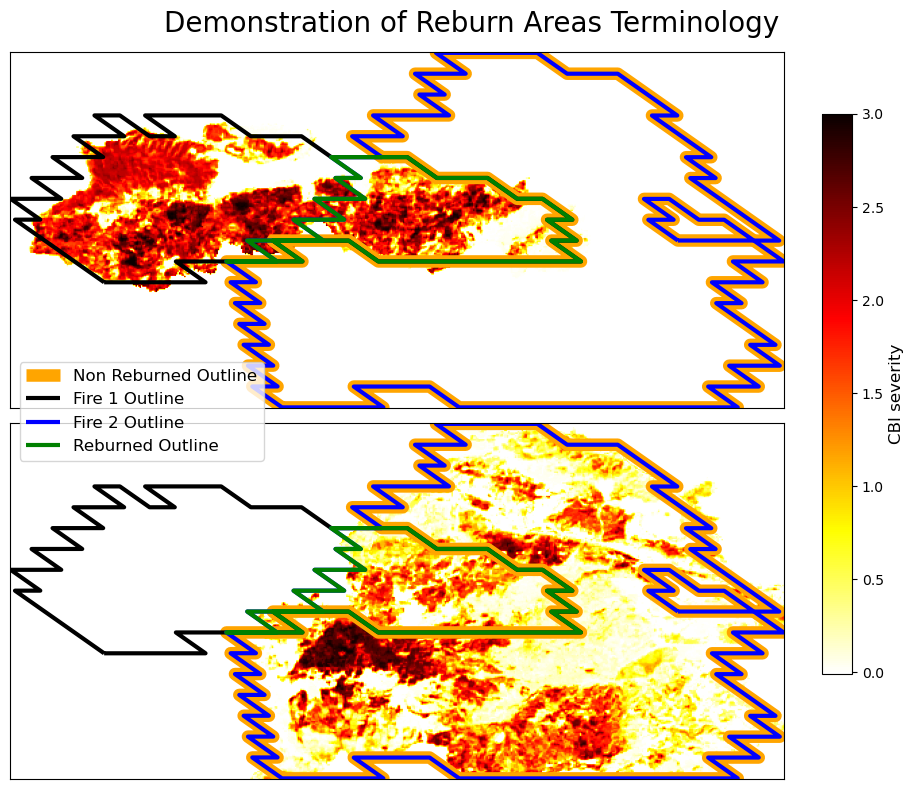

In [10]:
# Plotting a reburn event to visualize terminology

plot_fire_overlay(9308, 77658, 2002, "Demonstration of Reburn Areas Terminology", 2010)

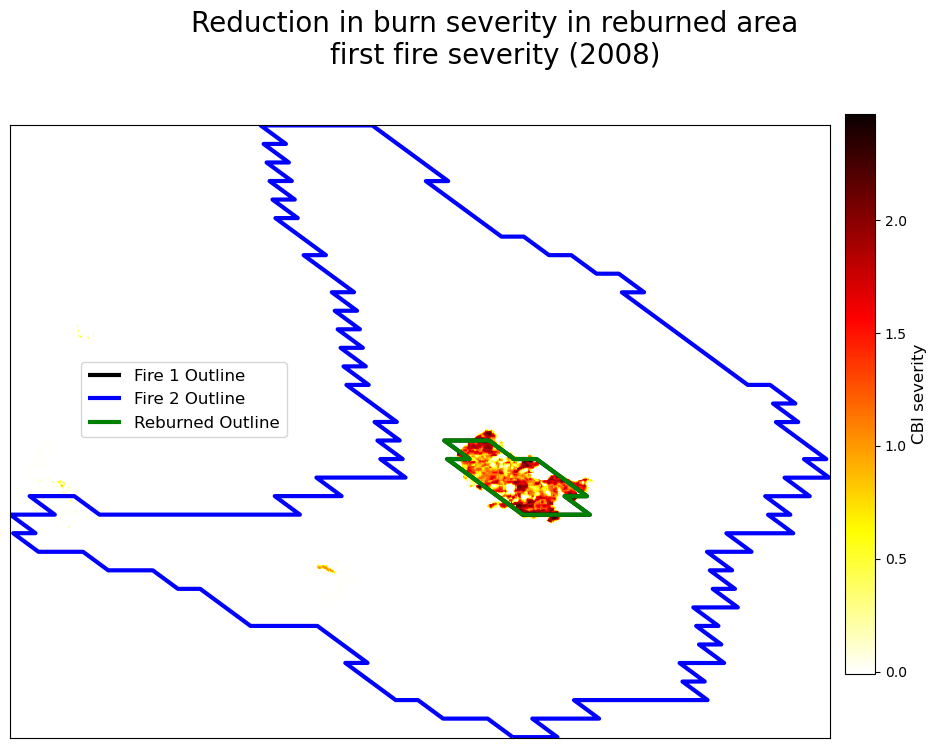

In [11]:
# Plotting the events seperately to see how severity changes in the reburned area

plot_fire_overlay(58770, 104108, 2008, "Reduction in burn severity in reburned area\nfirst fire severity (2008)")

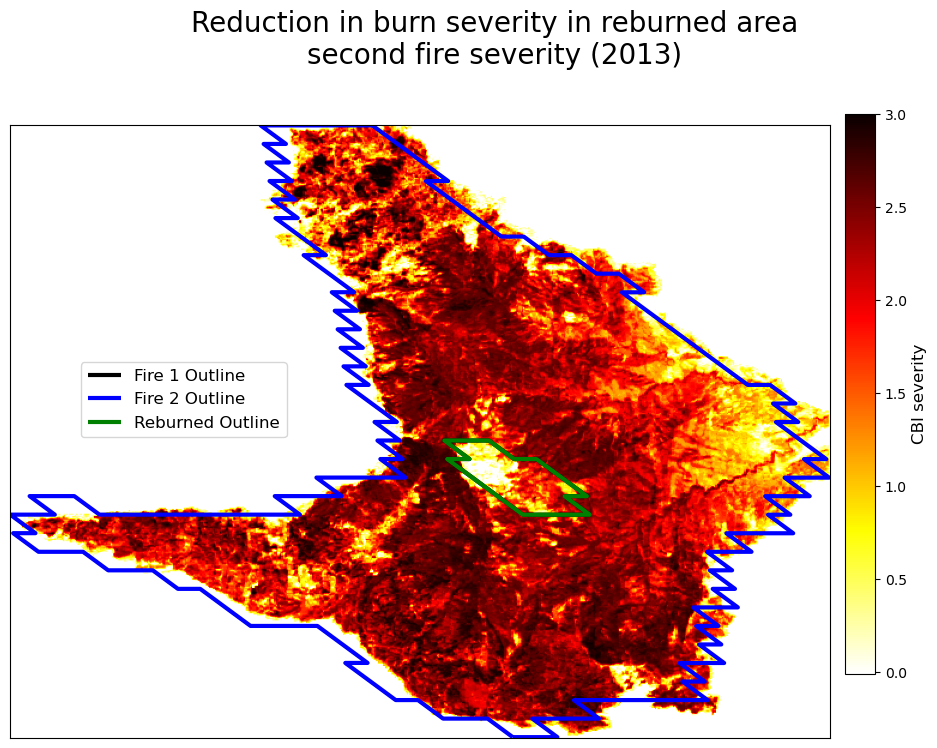

In [12]:
plot_fire_overlay(58770, 104108, 2013, "Reduction in burn severity in reburned area\nsecond fire severity (2013)")

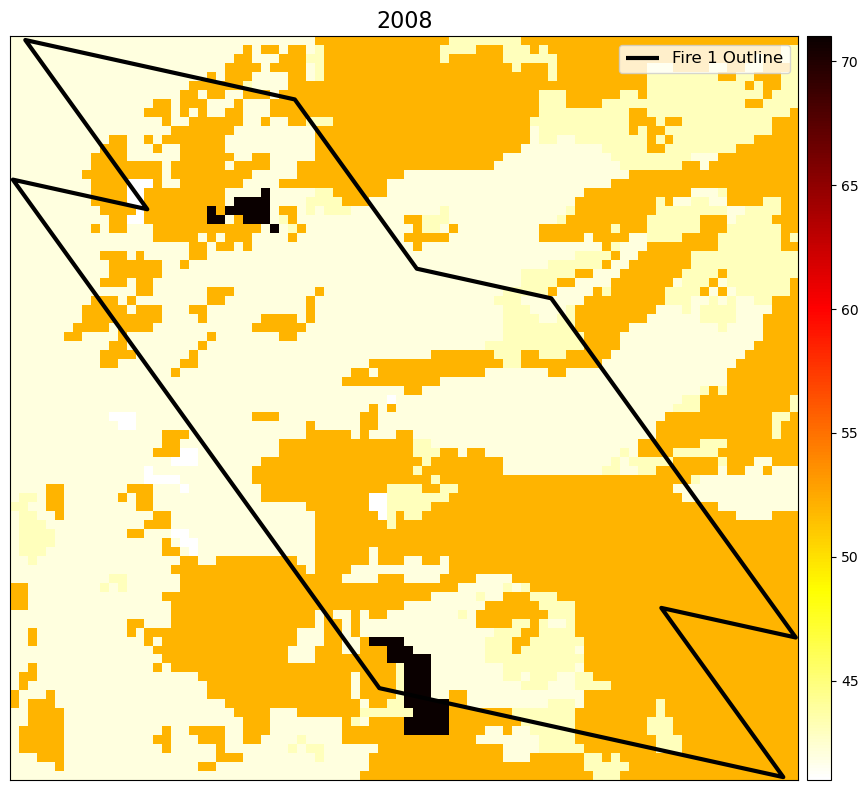

In [13]:
# Ensure the NLC is being pulled from the correct fires
plot_nlcd(58770, '/home/nathan/GitHub/firebegetsfire/data/NLCD/NLCD_clip2008.tif', 2008)

In [14]:
# Another NLCD check
fire1 = full_gdf[full_gdf["id"] == 58770].to_crs("EPSG:5070")
geo = fire1.geometry
check_forest_cover(2008, geo)

(42,
 54.11575562700964,
 '/home/nathan/GitHub/firebegetsfire/data/NLCD/NLCD_clip2008.tif')

In [15]:
# Print the average severity data from the dataset
full_avs = print_aves(large_reburns_no_na)

Year 1 fire average: 1.5373609735608011
Year 2 fire average: 1.5292038649356718
Non reburned average: 1.532428216613606
Reburned average: 1.2412608455321668
Reburn year 1 ave: 1.4883301319801305


In [16]:
# Print the average severity data in each year grouping dataset
lf_aves = print_aves(less_five)

Year 1 fire average: 1.4392610334504683
Year 2 fire average: 1.5414226925920678
Non reburned average: 1.5228868393202832
Reburned average: 1.0833314048426332
Reburn year 1 ave: 1.3716353022565062


In [17]:
ft_aves = print_aves(five_ten)

Year 1 fire average: 1.4744401790667325
Year 2 fire average: 1.4059617021240924
Non reburned average: 1.4179575194019194
Reburned average: 1.089353236647131
Reburn year 1 ave: 1.4232430126216702


In [18]:
tf_aves = print_aves(ten_fifteen)

Year 1 fire average: 1.6129144353605807
Year 2 fire average: 1.6154871960356831
Non reburned average: 1.6294080044329167
Reburned average: 1.4061385265737771
Reburn year 1 ave: 1.5576429144479333


In [19]:
# Find the shapiro test for the relevant columns in each grouping in order to
# ensure they are not normally distributed
get_shapiro(large_reburns_no_na)

Column ave_sev_1:
  Test Statistic: 0.9516654014587402
  p-value: 5.560164773044107e-09
Column ave_sev_2:
  Test Statistic: 0.9328910708427429
  p-value: 4.38511726930102e-11
Column reburn_ave_sev:
  Test Statistic: 0.9832580089569092
  p-value: 0.0006593287107534707
Column diff_av_sev:
  Test Statistic: 0.9351729154586792
  p-value: 7.510497085361223e-11
Column reburn_1_ave:
  Test Statistic: 0.9579992294311523
  p-value: 3.695758721278253e-08


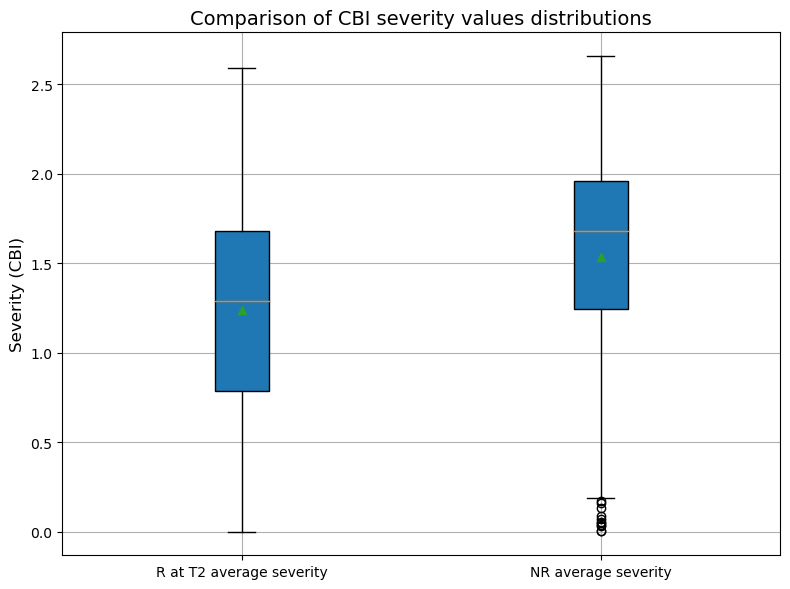

In [20]:
plot_severity_comparison(
    large_reburns_no_na, 
    "final_paper_box.png", 
    columns=["reburn_ave_sev", "diff_av_sev"], 
    titles=["R at T2 average severity", "NR average severity"]
)

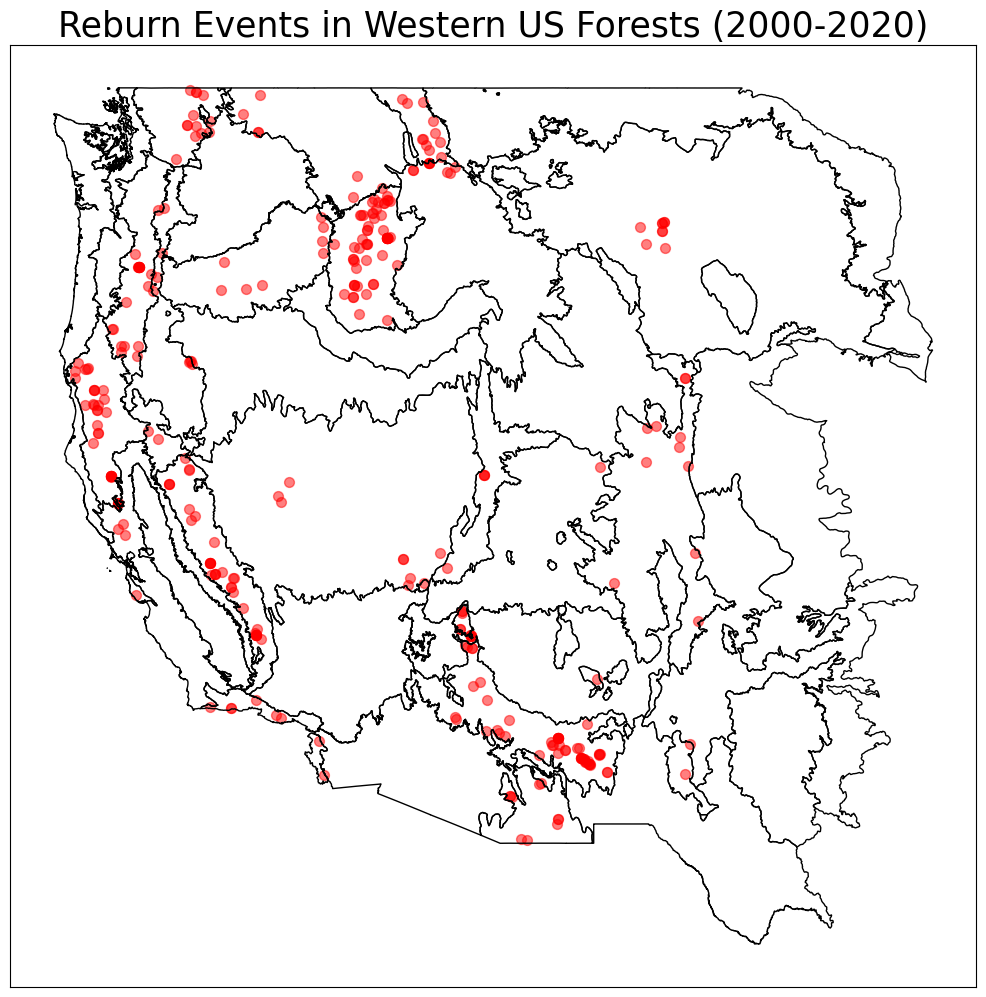

In [21]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot ecoregion boundaries
western_epa.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot overlay outlines with larger markers and transparency
large_reburns_no_na.centroid.plot(ax=ax, color='red', marker='o', markersize=50, alpha=0.5)


# Add title and axis labels
ax.set_title("Reburn Events in Western US Forests (2000-2020)", fontsize=25)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()


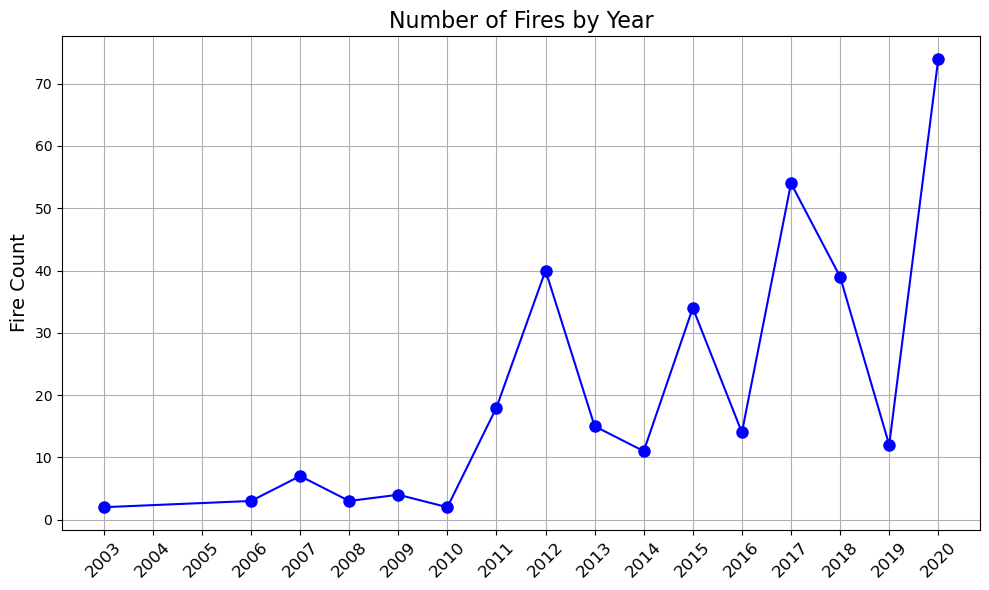

In [22]:
plot_fire_statistics_by_year(large_reburns_no_na, plot_type='count')

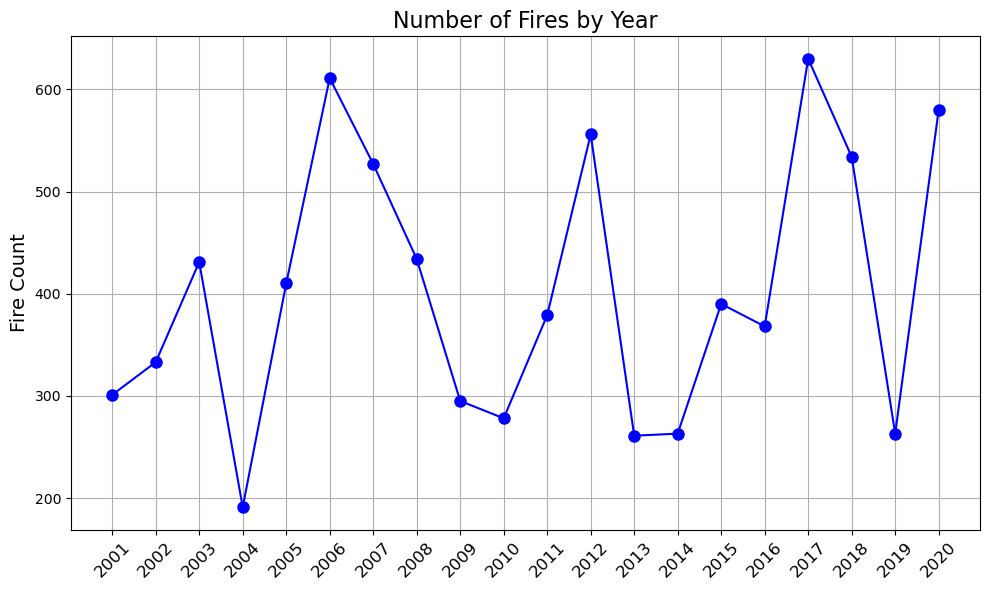

In [23]:
plot_fire_statistics_by_year(full_gdf, 'year', plot_type='count')

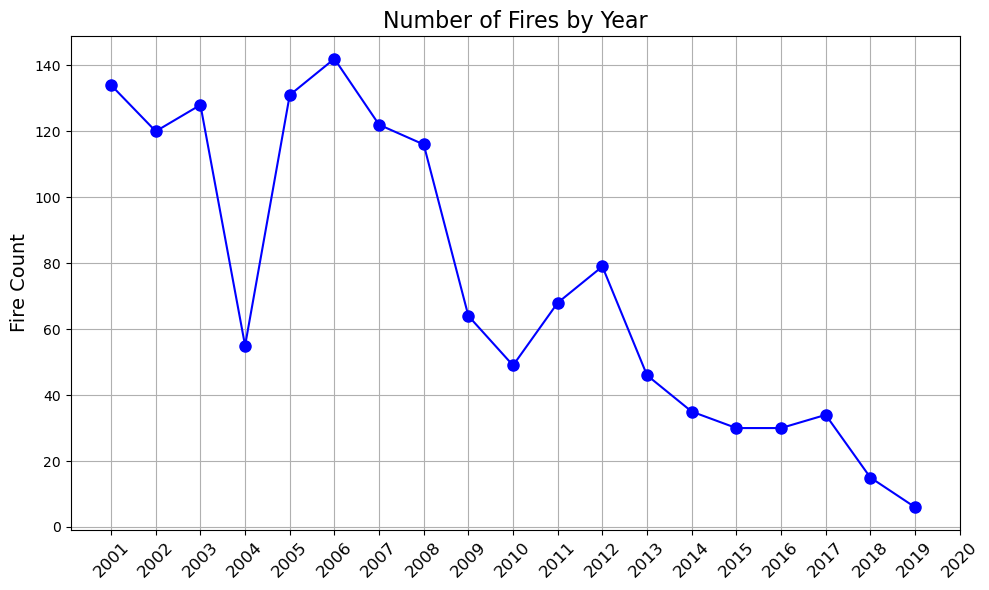

In [24]:
plot_fire_statistics_by_year(large_reburns, 'year_1', plot_type='count')

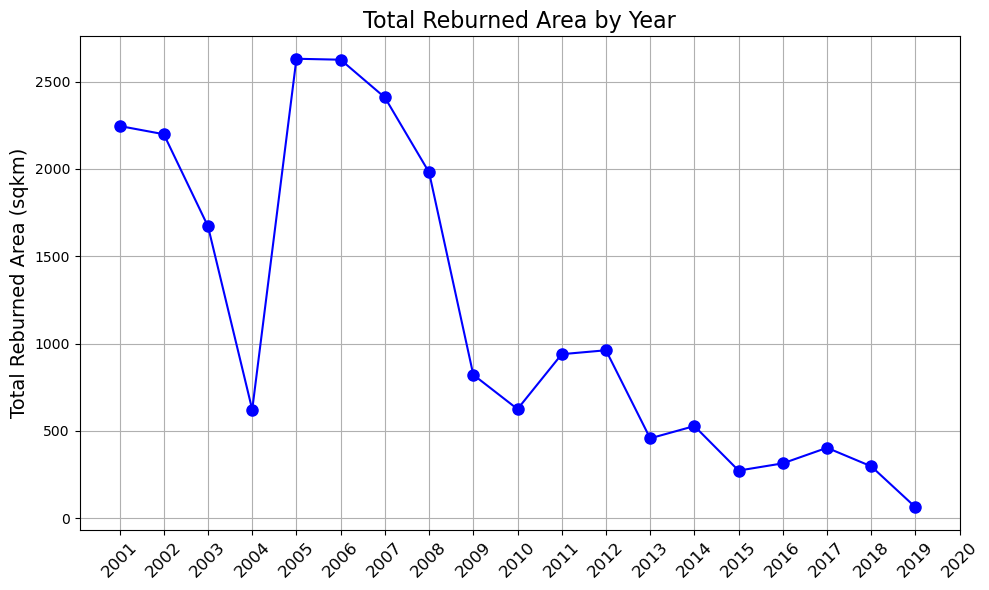

In [25]:
plot_fire_statistics_by_year(large_reburns, 'year_1', plot_type='area')

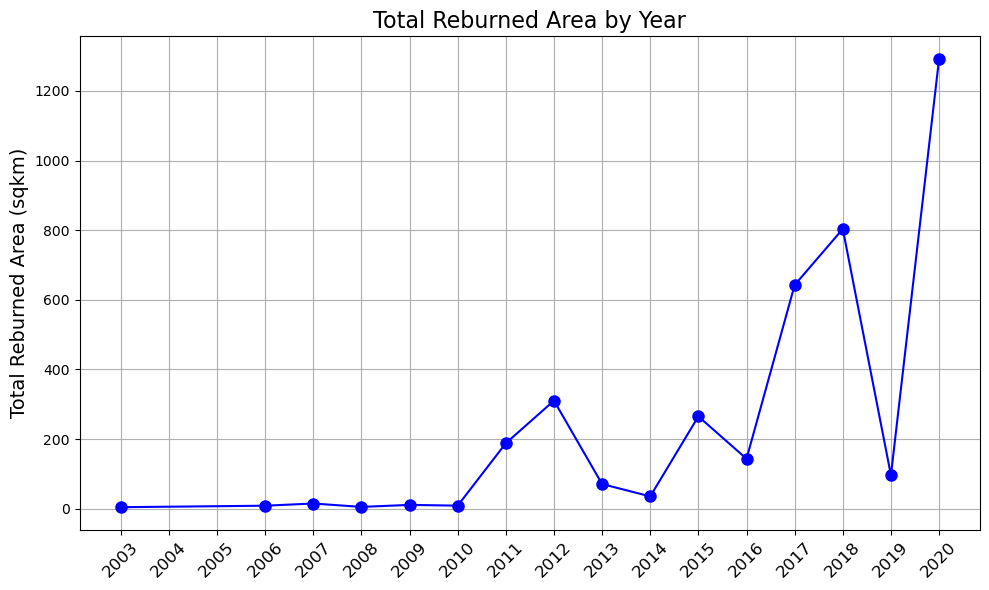

In [26]:
plot_fire_statistics_by_year(large_reburns_no_na, plot_type='area')

### Statistical differences

The section below gets needed data to fully understand the difference in 
severity distributions between different areas in the reburn events

In [27]:
# Find the standard deviation and inter-quartile range for the data
get_mean_sd_iqr(large_reburns_no_na)

R at T2
1.2412608455321668
0.6069888273449752
0.8937735706567764
----------
NR
1.532428216613606
0.5843311804054279
0.7148538827896118
----------
R at T1
1.4883301319801305
0.5304997245961004
0.6597550213336945
----------


In [28]:
get_mean_sd_iqr(less_five)

R at T2
1.0833314048426332
0.7164937509561855
1.116357870399952
----------
NR
1.5228868393202832
0.7099038533983894
0.8968742787837982
----------
R at T1
1.3716353022565062
0.6349798526592444
0.7436546683311462
----------


In [29]:
get_mean_sd_iqr(five_ten)

R at T2
1.089353236647131
0.5564799477388959
0.7516263127326965
----------
NR
1.4179575194019194
0.5823072284380572
0.8364969938993454
----------
R at T1
1.4232430126216702
0.5278041275201705
0.6948394775390625
----------


In [30]:
get_mean_sd_iqr(ten_fifteen)

R at T2
1.4061385265737771
0.5687619308276856
0.7080121636390686
----------
NR
1.6294080044329167
0.5310076328334955
0.601868063211441
----------
R at T1
1.5576429144479333
0.5018844215318459
0.5889911353588104
----------


In [31]:
# Compare columns of interest using a Mann Whitney U test since the 
# data is not normally distributed
mw_full = mannwhitney_compare(large_reburns_no_na)

Year 1 and Year 2 fire average
MannwhitneyuResult(statistic=53335.0, pvalue=0.4722608083987153)
Reburn and Non reburn fire average
MannwhitneyuResult(statistic=71417.0, pvalue=4.1944400048502245e-11)
Reburned area year 1 and 2 average
MannwhitneyuResult(statistic=68865.0, pvalue=2.6295867716117305e-08)


In [32]:
mw_lf = mannwhitney_compare(less_five) 

Year 1 and Year 2 fire average
MannwhitneyuResult(statistic=1149.0, pvalue=0.18799422651241082)
Reburn and Non reburn fire average
MannwhitneyuResult(statistic=1832.0, pvalue=0.001825039985482499)
Reburned area year 1 and 2 average
MannwhitneyuResult(statistic=1706.0, pvalue=0.021552146489988135)


In [33]:
mw_ft = mannwhitney_compare(five_ten)

Year 1 and Year 2 fire average
MannwhitneyuResult(statistic=9694.5, pvalue=0.49172065025908773)
Reburn and Non reburn fire average
MannwhitneyuResult(statistic=12485.0, pvalue=6.057547501428296e-07)
Reburned area year 1 and 2 average
MannwhitneyuResult(statistic=12635.0, pvalue=1.783314447480806e-07)


In [34]:
mw_tf = mannwhitney_compare(ten_fifteen)

Year 1 and Year 2 fire average
MannwhitneyuResult(statistic=4847.0, pvalue=0.709430126829107)
Reburn and Non reburn fire average
MannwhitneyuResult(statistic=6363.0, pvalue=0.0008712168524029091)
Reburned area year 1 and 2 average
MannwhitneyuResult(statistic=5765.0, pvalue=0.061766140544118324)


In [35]:
# Summarize the severity differences in a single dictionary for ease of access
summary_table_sev_dict = {'Reburn Periods Included': ['1-5', '6-10', '11-15'], 
                    'Full First Fire Average Severity': [round(lf_aves[0], 4), round(ft_aves[0], 4), round(tf_aves[0], 4)], 
                    'Full Second Fire Average Severity': [round(lf_aves[1], 4), round(ft_aves[1], 4), round(tf_aves[1], 4)],
                    'First Fire Reburned Area Average Severity': [round(lf_aves[4], 4), round(ft_aves[4], 4), round(tf_aves[4], 4)],
                    'Second Fire Non Reburned Area Average Severity': [round(lf_aves[2], 4), round(ft_aves[2], 4), round(tf_aves[2], 4)],
                    'Second Fire Reburned Area Average Severity': [round(lf_aves[3], 4), round(ft_aves[3], 4), round(tf_aves[3], 4)]}

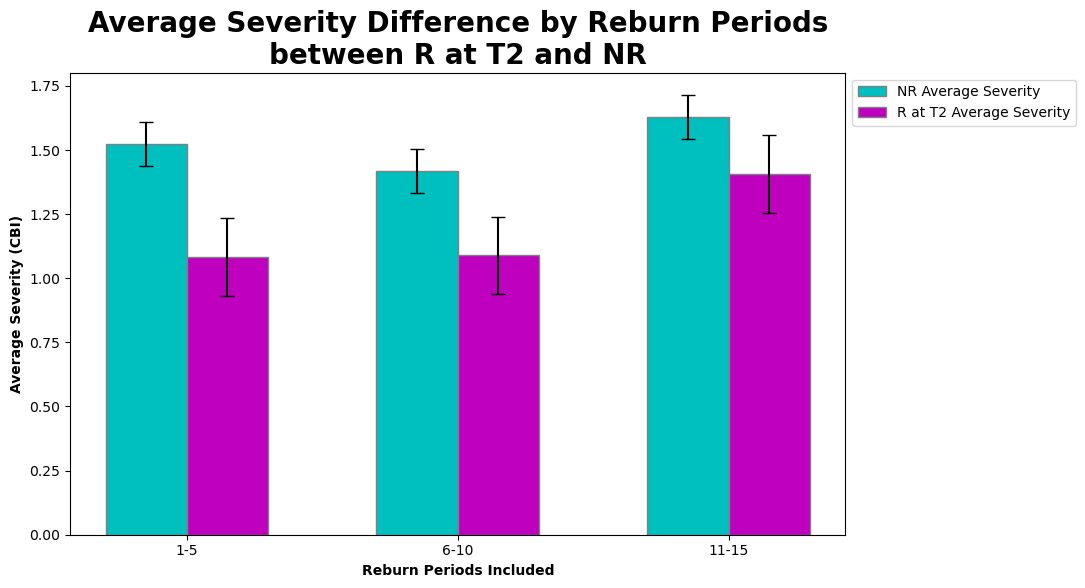

In [36]:
# Plot the difference between R at T2 and NR
plot_nr_v_rt2(summary_table_sev_dict)

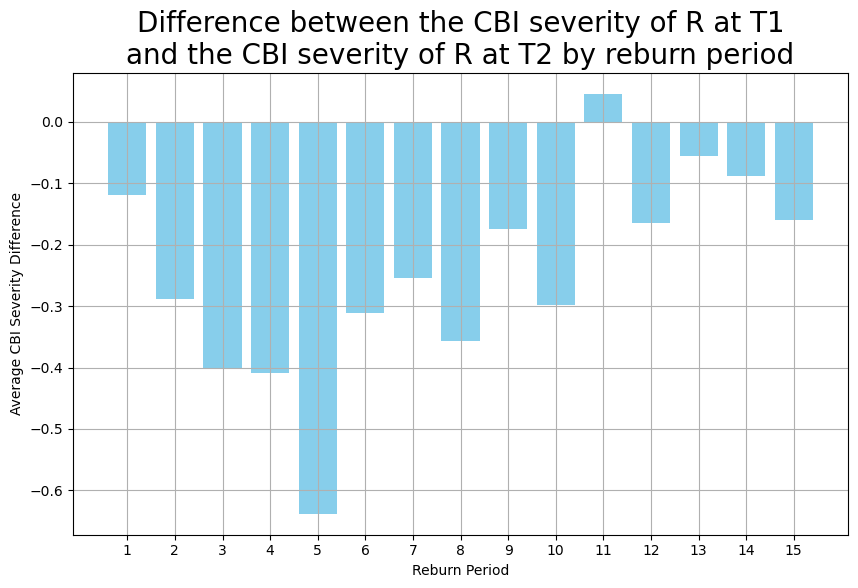

In [37]:
# Create a dataset only looking at fires that have a reburn period shorter
# than fifteen years in order to see how the different year gaps affect the 
# severity differences between different data relationships
less_than_fifteen = large_reburns_no_na[large_reburns_no_na['year_gap'] <= 15]
plot_year_gap_column_difference(less_than_fifteen, 'reburn_1_ave', 'reburn_ave_sev')

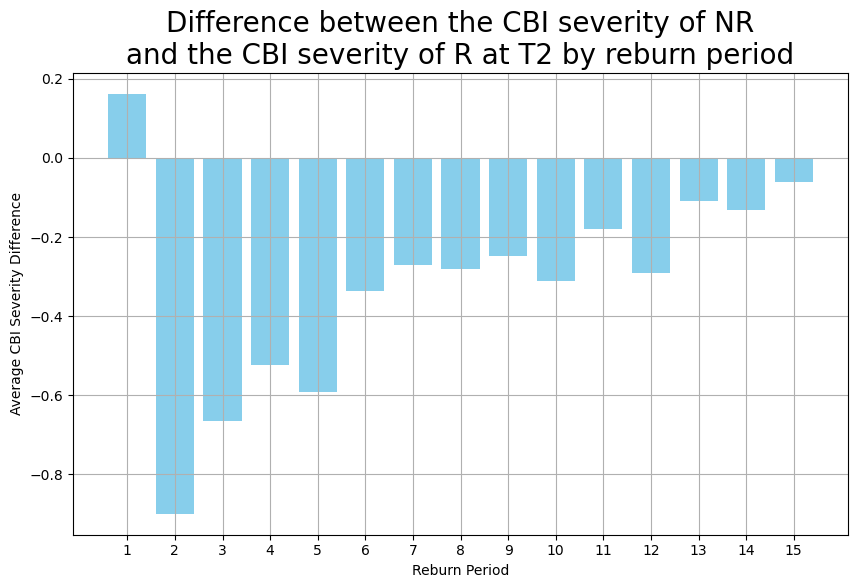

In [38]:
plot_year_gap_column_difference(less_than_fifteen, 'diff_av_sev', 'reburn_ave_sev')

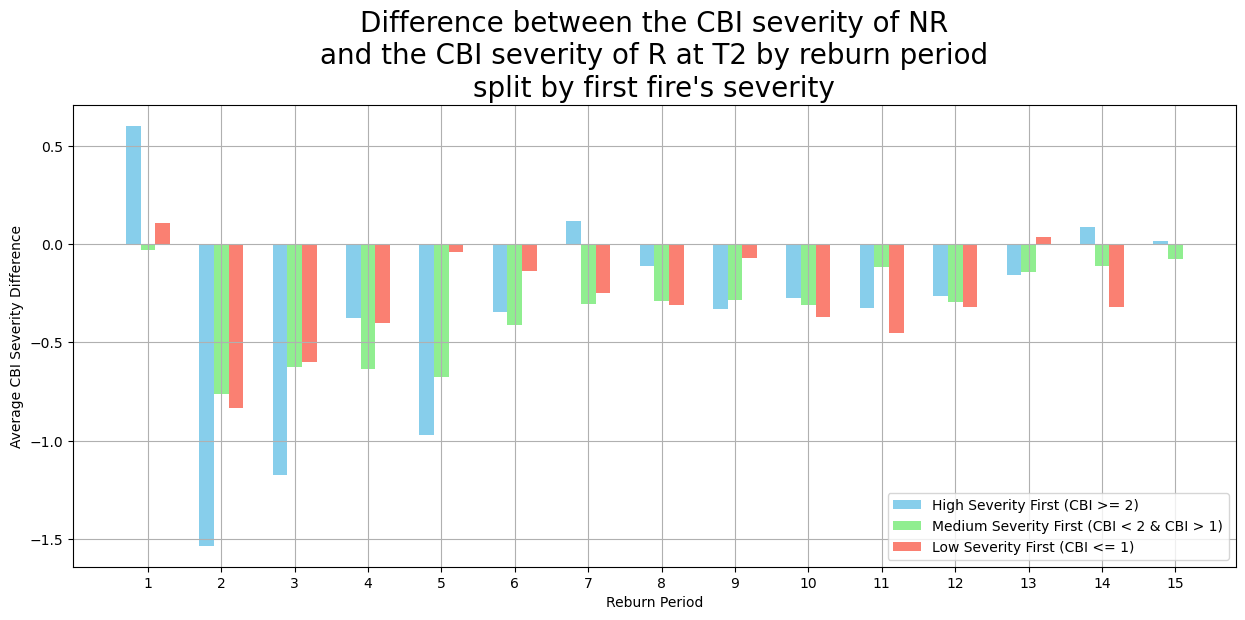

In [39]:
# Split the data into fires that had a high, medium, and low severity first 
# fire to see how the varying intial severity affects the second fire
high_first = less_than_fifteen[less_than_fifteen['reburn_1_ave'] >= 2]
mid_first = less_than_fifteen[(less_than_fifteen['reburn_1_ave'] < 2) & (less_than_fifteen['reburn_1_ave'] > 1)]
low_first = less_than_fifteen[less_than_fifteen['reburn_1_ave'] <= 1]

plot_year_gap_column_difference_breakout(high_first, mid_first, low_first, 'diff_av_sev', 'reburn_ave_sev')

### Spatio-temporal variance

This section focuses on the variance in severity differences based on geography,
reburn period, and the year the fires occured.

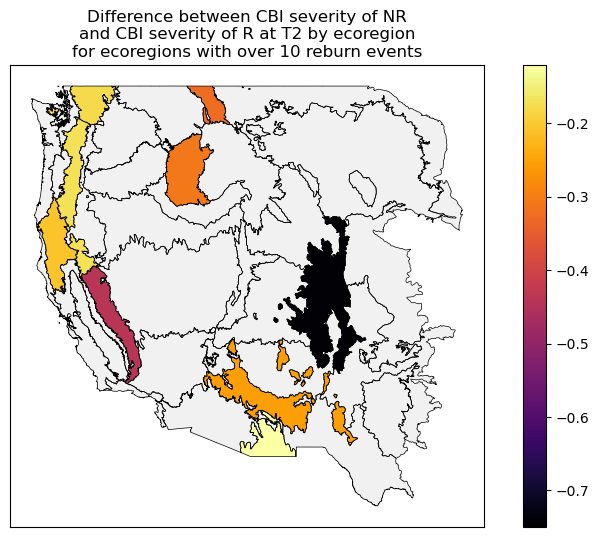

In [40]:
# Create a map visualizing the different between R at T2 and NR severity spatially
map_ecoregion_column_difference(large_reburns_no_na, western_epa, 'diff_av_sev', 'reburn_ave_sev')

In [41]:
# Find the average difference in size between the reburned area and the full size
# of the second fire
reburn_v_fire2_area = large_reburns_no_na['reburn_area']/(large_reburns_no_na['diff_area'] + large_reburns_no_na['reburn_area'])
np.mean(reburn_v_fire2_area)

0.15064673070383794

In [42]:
# Count how many reburns occur in each ecoregion
code, count = [], []

for i, group in large_reburns_no_na.groupby("ecoregion"):
        code.append(i)
        count.append(len(group))

reburn_count = pd.DataFrame({"US_L3CODE":code, "num":count}, index=list(range(len(code)))).sort_values(by='num', ascending=False).reset_index()

In [43]:
# Get data needed to see how the difference in severity between R at T2 and NR
# changes overtime
gaps_int = [(1, 5), (6, 10), (11, 15)]
colors = ['blue', 'green', 'red']
labels = ["5 or less years", "Between 6 and 10 years", "Between 11 and 15 years"]

results = {}
for gaps in gaps_int:
    output = gap_analysis(gaps[0], gaps[1], large_reburns_no_na)
    results[gaps] = output

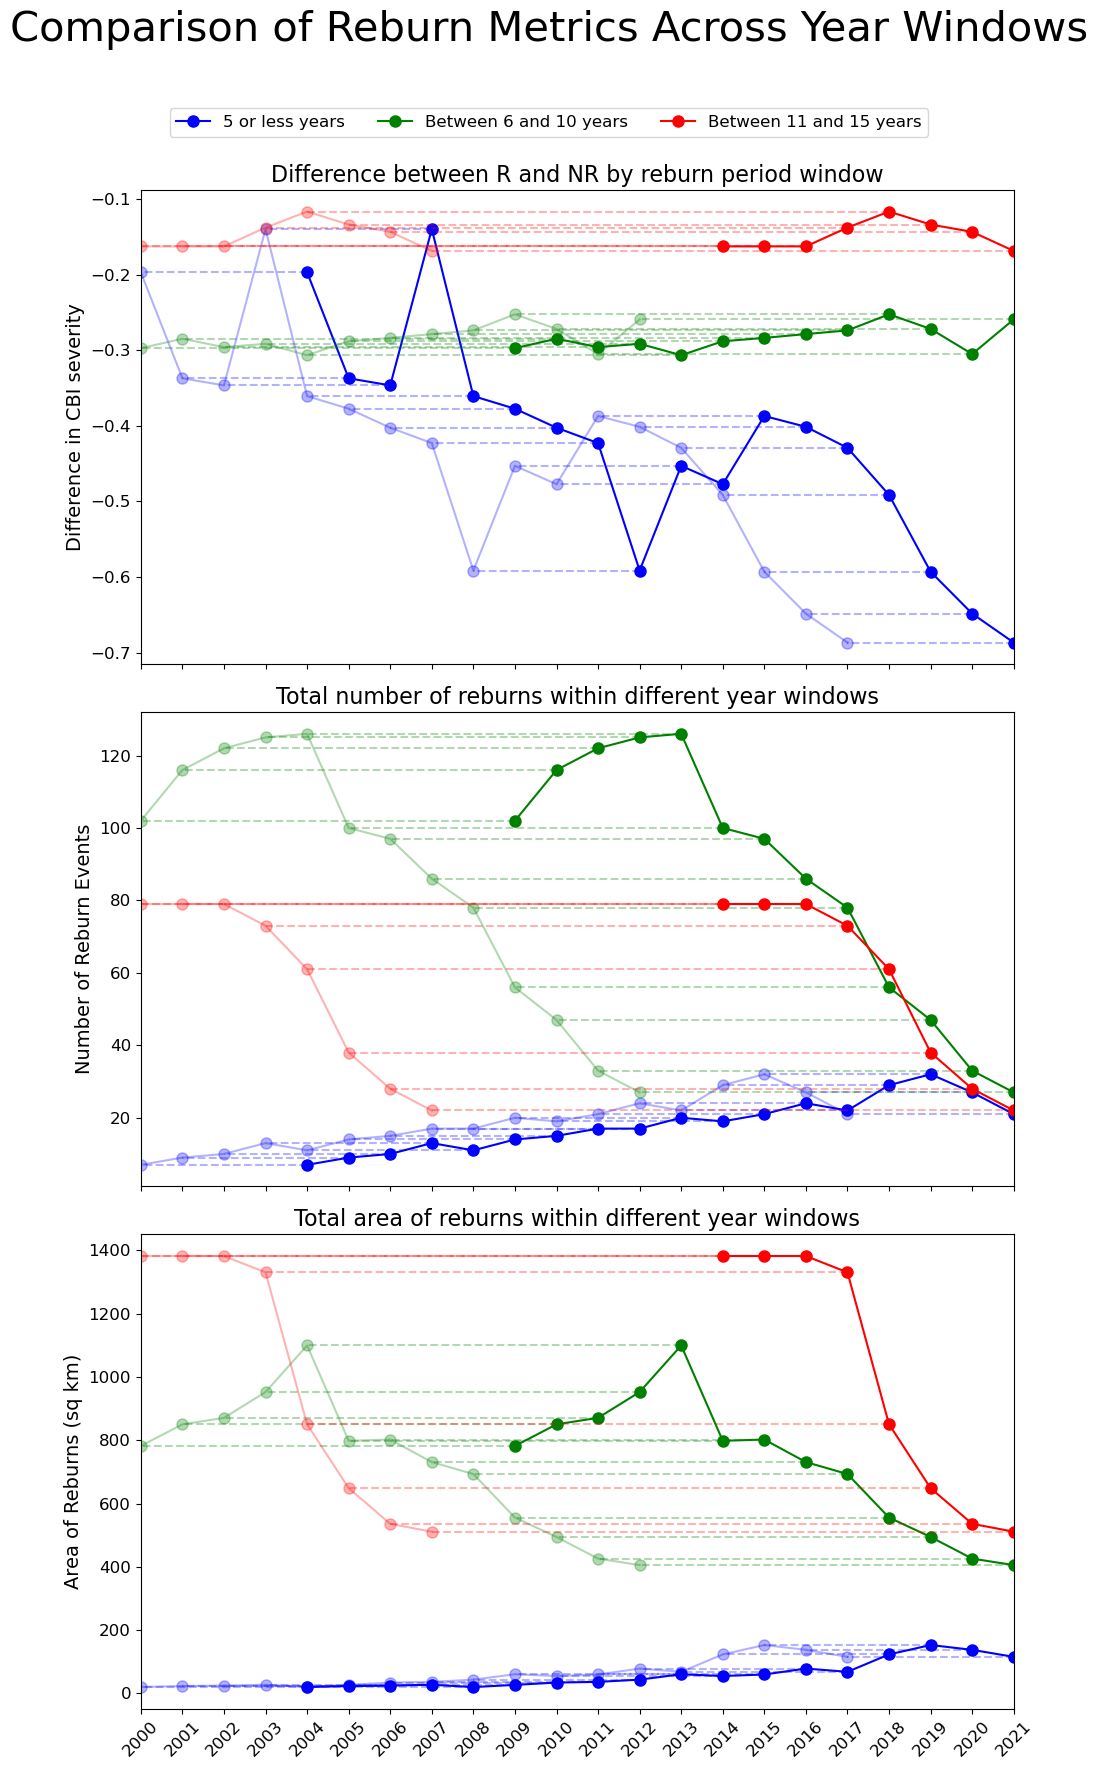

In [44]:
# Plot the results
plot_year_gaps(results, gaps_int, colors, labels)

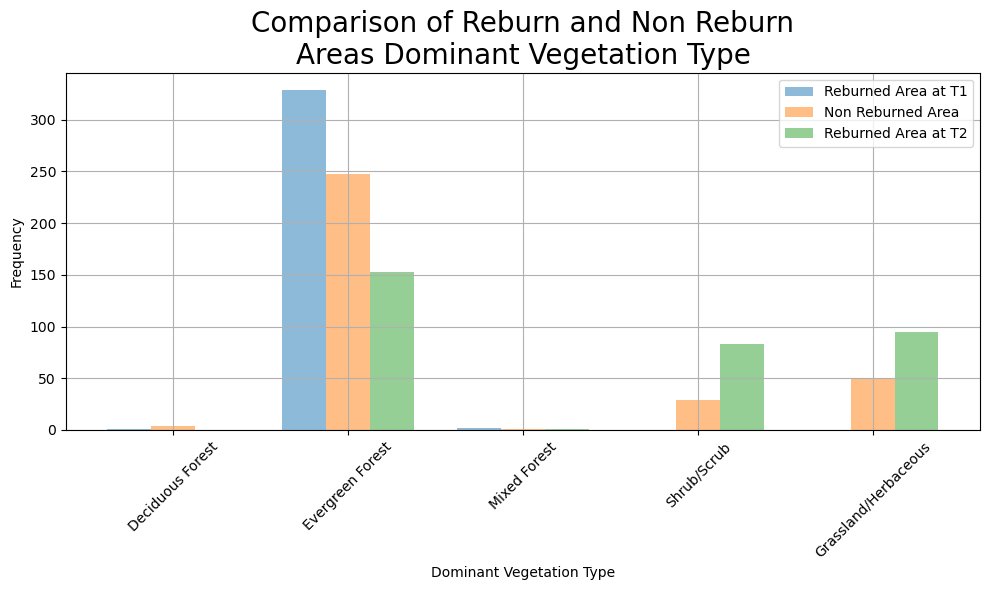

In [45]:
# Plot the dominante forest type for each fire
str_diff = large_reburns_no_na['diff_forest'].astype(str)
categories = sorted(set(large_reburns_no_na['reburn_forest'].unique()) | set(large_reburns_no_na['reburn1_forest'].unique()) | set(str_diff.unique()))

nlcd_land_cover_types = {
    0: 'Water',
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land (Rock/Sand/Clay)',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    51: 'Dwarf Scrub',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    72: 'Sedge/Herbaceous',
    73: 'Lichens',
    74: 'Moss',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

nlcd_labels = [nlcd_land_cover_types[int(key)] for key in categories]

# Count occurrences of each category in 'reburn_forest' and 'reburn1_forest' columns
counts_reburn_forest = large_reburns_no_na['reburn_forest'].value_counts().reindex(categories, fill_value=0)
counts_reburn1_forest = large_reburns_no_na['reburn1_forest'].value_counts().reindex(categories, fill_value=0)
counts_diff_forest = str_diff.value_counts().reindex(categories, fill_value=0)

plt.figure(figsize=(10, 6))
bar_width = 0.25  # Reduce the width to accommodate three bars
index = range(len(categories))

# Plot the bars for counts_reburn_forest
plt.bar(index, counts_reburn1_forest, bar_width, alpha=0.5, label='Reburned Area at T1')

# Plot the bars for counts_reburn1_forest
plt.bar([i + bar_width for i in index], counts_diff_forest, bar_width, alpha=0.5, label='Non Reburned Area')

# Plot the bars for counts_diff_forest
plt.bar([i + 2*bar_width for i in index], counts_reburn_forest, bar_width, alpha=0.5, label='Reburned Area at T2')

plt.xlabel('Dominant Vegetation Type')
plt.ylabel('Frequency')
plt.title('Comparison of Reburn and Non Reburn\nAreas Dominant Vegetation Type', size=20)
plt.xticks([i + bar_width for i in index], nlcd_labels, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


### Independant variable analysis

This section compares independant variables that can further explain the 
difference we see in reburn severity 

In [46]:
def analyze_variable(df, variable, cutoff, reburn_col, diff_col):
    """
    Perform analysis for a given variable by splitting data into high and low groups, 
    calculating averages and differences, and performing Mann-Whitney U tests.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data to analyze.
    variable : str
        The column name of the variable to analyze (e.g., 'reburn_elev', 'reburn_slope').
    cutoff : float or int
        The cutoff value to split the data into high and low groups.
    reburn_col : str
        The column name representing the reburned area severity (e.g., 'reburn_ave_sev').
    diff_col : str
        The column name representing the non-reburned area severity (e.g., 'diff_av_sev').

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the results of the analysis.
    """
    # Split data into high and low groups based on the cutoff value
    high_group = df[df[variable] >= cutoff]
    low_group = df[df[variable] < cutoff]
    
    # Calculate means
    high_mean = high_group[reburn_col].mean()
    low_mean = low_group[reburn_col].mean()

    # Calculate differences within each group
    high_diffs = high_group[reburn_col] - high_group[diff_col]
    low_diffs = low_group[reburn_col] - low_group[diff_col]

    # Perform Mann-Whitney U tests
    mw_reburn = sp.stats.mannwhitneyu(high_group[reburn_col], low_group[reburn_col])
    mw_diffs = sp.stats.mannwhitneyu(high_diffs, low_diffs)
    mw_variable = sp.stats.mannwhitneyu(df[variable], df[diff_col])

    # Create a dictionary to store results
    results = {
        'High Group Reburned Area Mean Severity': f"{high_mean:.2f}",
        'Low Group Reburned Area Mean Severity': f"{low_mean:.2f}",
        'High Group Mean Difference (Reburned - Non-reburned)': f"{high_diffs.mean():.2f}",
        'Low Group Mean Difference (Reburned - Non-reburned)': f"{low_diffs.mean():.2f}",
        'Difference Between High and Low Group Mean Differences': f"{high_diffs.mean() - low_diffs.mean():.2f}",
        'Mann-Whitney U p-value (High vs Low Reburn Severity)': mw_reburn.pvalue,
        'Mann-Whitney U p-value (High vs Low Differences)': mw_diffs.pvalue,
        'Mann-Whitney U p-value (Variable vs Difference)': mw_variable.pvalue
    }

    return pd.DataFrame.from_dict(results, orient='index')

In [47]:
# Check how elevation effects the relationship between R at T2 and NR
elevation_results = analyze_variable(
    large_reburns_no_na, 
    variable='reburn_elev', 
    cutoff=1800, 
    reburn_col='reburn_ave_sev', 
    diff_col='diff_av_sev'
)

print("Elevation Results:", elevation_results)

Elevation Results:                                                            0
High Group Reburned Area Mean Severity                  1.10
Low Group Reburned Area Mean Severity                   1.39
High Group Mean Difference (Reburned - Non-rebu...     -0.33
Low Group Mean Difference (Reburned - Non-rebur...     -0.25
Difference Between High and Low Group Mean Diff...     -0.07
Mann-Whitney U p-value (High vs Low Reburn Seve...  0.000013
Mann-Whitney U p-value (High vs Low Differences)    0.198832
Mann-Whitney U p-value (Variable vs Difference)          0.0


In [48]:
# Slope analysis
slope_results = analyze_variable(
    large_reburns_no_na, 
    variable='reburn_slope', 
    cutoff=34, 
    reburn_col='reburn_ave_sev', 
    diff_col='diff_av_sev'
)

print("Slope Results:", slope_results)

Slope Results:                                                            0
High Group Reburned Area Mean Severity                  1.33
Low Group Reburned Area Mean Severity                   1.15
High Group Mean Difference (Reburned - Non-rebu...     -0.28
Low Group Mean Difference (Reburned - Non-rebur...     -0.31
Difference Between High and Low Group Mean Diff...      0.03
Mann-Whitney U p-value (High vs Low Reburn Seve...  0.013968
Mann-Whitney U p-value (High vs Low Differences)    0.596083
Mann-Whitney U p-value (Variable vs Difference)          0.0


In [49]:
vpd_results = analyze_variable(
    large_reburns_no_na, 
    variable='reburn_vpd', 
    cutoff=1.3, 
    reburn_col='reburn_ave_sev', 
    diff_col='diff_av_sev'
)

print("VPD Results:", vpd_results)

VPD Results:                                                            0
High Group Reburned Area Mean Severity                  1.14
Low Group Reburned Area Mean Severity                   1.34
High Group Mean Difference (Reburned - Non-rebu...     -0.31
Low Group Mean Difference (Reburned - Non-rebur...     -0.27
Difference Between High and Low Group Mean Diff...     -0.04
Mann-Whitney U p-value (High vs Low Reburn Seve...  0.002069
Mann-Whitney U p-value (High vs Low Differences)     0.43134
Mann-Whitney U p-value (Variable vs Difference)     0.000001


In [50]:
# Reminder of actual difference
sp.stats.mannwhitneyu(large_reburns_no_na['reburn_ave_sev'], large_reburns_no_na['diff_av_sev'])

MannwhitneyuResult(statistic=38807.0, pvalue=4.1944400048502245e-11)

In [51]:
print(large_reburns_no_na['reburn_ave_sev'].mean() - large_reburns_no_na['diff_av_sev'].mean())
print(percent_drop(large_reburns_no_na['diff_av_sev'].mean(), large_reburns_no_na['reburn_ave_sev'].mean()))

-0.2911673710814393
19.000392183124077


ChatGPT was used to assist with docstrings and some of the functions. All 
concepts and workflows were developed by me. 